# Koronaviruksen jätevesiseuranta

Jätevesitilasto © THL (lisenssillä [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/deed.fi))

https://www.thl.fi/episeuranta/jatevesi/jatevesiseuranta_viikkoraportti.html

In [1]:
from datetime import datetime
from jatevedet_fi_thl import *

In [2]:
%config InlineBackend.figure_formats = ['png2x']  # png, png2x, jpg, svg
view_dpi = 90

In [3]:
data = pd.read_csv("data/Koronaviruksen jätevesiseurannan viikkoraportti 2022-09-23.csv",
                   parse_dates=["Näytteen päivämäärä"], date_parser=datetime.fromisoformat)

In [4]:
data.iloc[:20]

,Näytteen päivämäärä,Puhdistamo,Puhdistamon sijainti,Puhdistamon asiakasmäärä,Sairaanhoitopiiri,Näytetyyppi,Koronavirustulos näytteestä,Epävarmuustekijät,Virtaama,Virtaamakorjattu RNA-lukumäärä
0,2022-09-19,Suomenoja,Espoo,390000,Helsingin ja Uudenmaan SHP,Tuleva jätevesi,"havaittu, yli määritysrajan",NaN,88086,114241.0
1,2022-09-19,Viikinmäki,Helsinki,860000,Helsingin ja Uudenmaan SHP,Tuleva jätevesi,"havaittu, yli määritysrajan",NaN,218008,112335.0
2,2022-09-19,Kuhasalo,Joensuu,98000,Pohjois-Karjalan SHP,Tuleva jätevesi,"havaittu, yli määritysrajan",b,14318,113729.0
3,2022-09-19,Nenäinniemi,Jyväskylä,154600,Keski-Suomen SHP,Tuleva jätevesi,"havaittu, yli määritysrajan",NaN,32922,147536.0
4,2022-09-19,Lehtoniemi,Kuopio,90697,Pohjois-Savon SHP,Tuleva jätevesi,"havaittu, yli määritysrajan",NaN,13367,138369.0
5,2022-09-19,Toikansuo,Lappeenranta,63000,Etelä-Karjalan SHP,Tuleva jätevesi,"havaittu, yli määritysrajan",b,11132,114031.0
6,2022-09-19,Taskila,Oulu,200000,Pohjois-Pohjanmaan SHP,Tuleva jätevesi,"havaittu, yli määritysrajan",NaN,46278,103165.0
7,2022-09-19,Alakorkalo,Rovaniemi,55000,Lapin SHP,Tuleva jätevesi,"havaittu, yli määritysrajan",NaN,14600,258062.0
8,2022-09-19,Seinäjoenkeskuspuhdistamo,Seinäjoki,55000,Etelä-Pohjanmaan SHP,Tuleva jätevesi,"havaittu, yli määritysrajan",NaN,15664,32379.0
9,2022-09-19,Viinikanlahti,Tampere,200000,Pirkanmaan SHP,Tuleva jätevesi,"havaittu, yli määritysrajan",NaN,62081,207437.0


In [5]:
df, dates, mittaukset_n, epvt_n, puhdistamot = valmistele_data(data)
keskiarvot, painotetut_ka = trendien_keskiarvot(df, puhdistamot)

Ikkunan leveys
  Ikkunan painosta 100%: 63.0 päivää (kertoimia 127 kpl)
  Ikkunan painosta 51.06% >= 50%: 14.0 päivää
  Ikkunan painosta 80.19% >= 80%: 26.0 päivää
  Ikkunan painosta 90.24% >= 90%: 33.0 päivää
  Ikkunan painosta 95.42% >= 95%: 39.0 päivää
  Ikkunan painosta 99.04% >= 99%: 48.0 päivää


In [6]:
# Järjestetään puhdistamot asiakasmäärien mukaan laskevasti
asiakasmaarat = df["Puhdistamon asiakasmäärä"][puhdistamot].max(axis=0)
puhdistamot = np.array(puhdistamot)[np.argsort(asiakasmaarat)[::-1]]

## Epävarmuustekijät viimeaikaisissa näytteissä

Sarakkeen [kuvauksesta](https://www.thl.fi/episeuranta/jatevesi/jatevesiseuranta_viikkoraportti.html):

> Taulukkoriville on lisätty kirjainsymboli (a, b tai c), mikäli saatuun SARS-CoV-2 koronaviruksen RNA-tuloksen analysointiin liittyy yksi tai useampi tuloksen luotettavuutta heikentävä epävarmuustekijä.
> 
> * a = näytteen lämpötila yli 15 astetta näytteen saapuessa laboratorioon.
> * b = näytteessä on todettu määritystä häiritseviä tekijöitä (inhibitio).
> * c = yli 14vrk viive näytteen keräämisen ja analyysin aloituksen välillä, kertanäyte tai poikkeava keräysaika.
> * () = epävarmuustekijää ei ole testattu tai tieto puuttuu.


In [7]:
df["Epävarmuustekijät"][puhdistamot].dropna(how="all").iloc[-1:-9:-1].T

,2022-09-19,2022-09-05,2022-08-29,2022-08-22,2022-08-15,2022-08-10,2022-08-08,2022-08-01
Puhdistamo,,,,,,,,
"Helsinki, Viikinmäki",NaN,b,NaN,NaN,NaN,NaN,b,(b)
"Espoo, Suomenoja",NaN,NaN,b,NaN,NaN,NaN,b,(b)
"Turku, Kakolanmäki",NaN,b,b,NaN,NaN,NaN,b,NaN
"Tampere, Viinikanlahti",NaN,b,NaN,NaN,NaN,NaN,b,NaN
"Oulu, Taskila",NaN,b,b,NaN,NaN,NaN,b,NaN
"Jyväskylä, Nenäinniemi",NaN,b,b,NaN,NaN,NaN,NaN,NaN
"Pori, Luotsinmäki",NaN,NaN,b,NaN,NaN,b,NaN,(b)
"Joensuu, Kuhasalo",b,a b,b,b,b,NaN,b,b
"Kuopio, Lehtoniemi",NaN,NaN,b,NaN,NaN,NaN,b,NaN


In [8]:
xlim = {
    "left": dates[-1] - np.timedelta64(12 * 28 + 2, "D"),
    "right": dates[-1] + np.timedelta64(2, "D"),
}

ylim = {
    "top": 1.2,
}

## Historiaan suhteutettujen mittaustulosten jakauma koko maassa

Kunkin puhdistamon virtaamakorjattuun dataan on sovitettu trendi (liukuva keskiarvo), joka tasoittaa viikottaista vaihtelua. Yllä tuloste ikkunan leveydestä kertoo, kuinka pitkältä aikaväliltä mittaustuloksia huomioidaan. Puhdistamon data normalisoidaan jakamalla jokainen virtaamakorjattu mittaustulos trendikäyrän maksimiarvolla. Puhdistamon mittaustuloksia verrataan siis sen omaan menneisyyteen – sen tähän asti pahimpaan epidemiatilanteeseen.

Normalisoinnin yksi tarkoitus on häivyttää alueiden väliset tuntemattomat erot vakio-olosuhteissa, jotka voivat ilmetä paikallisina eroina koronan leviämiskyvyssä tai sairastuneen tuottaman jätevesisignaalin voimakkuudessa. Lisäksi normalisoitujen mittaustulosten jakauman muutokset havainnollistavat hyvin paikallisten epidemiatilanteiden muutoksia ja "samantahtisuutta" koko maassa.

Alla olevassa kaaviossa on normalisoitujen mittaustulosten jakauma ajan funktiona.

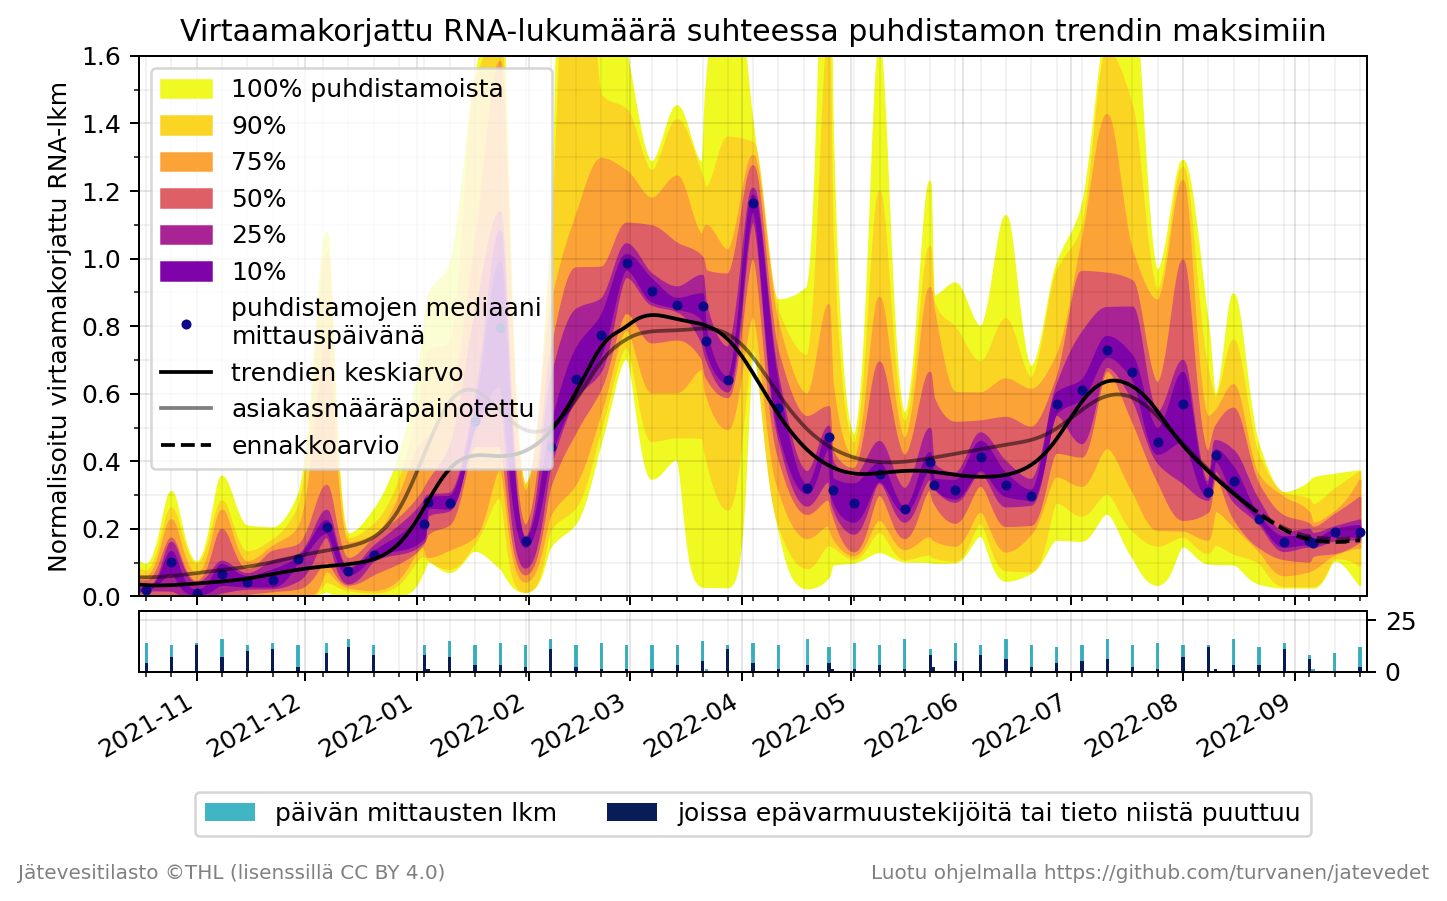

In [9]:
fig, ax = jakaumakaavio(df, dates, mittaukset_n, epvt_n, puhdistamot, 
                        keskiarvot=keskiarvot,
                        painotetut_ka=painotetut_ka,
                        xlim_kw=xlim,
                        ylim_kw={"top": 1.6},
                        dpi=view_dpi)

## Trendit

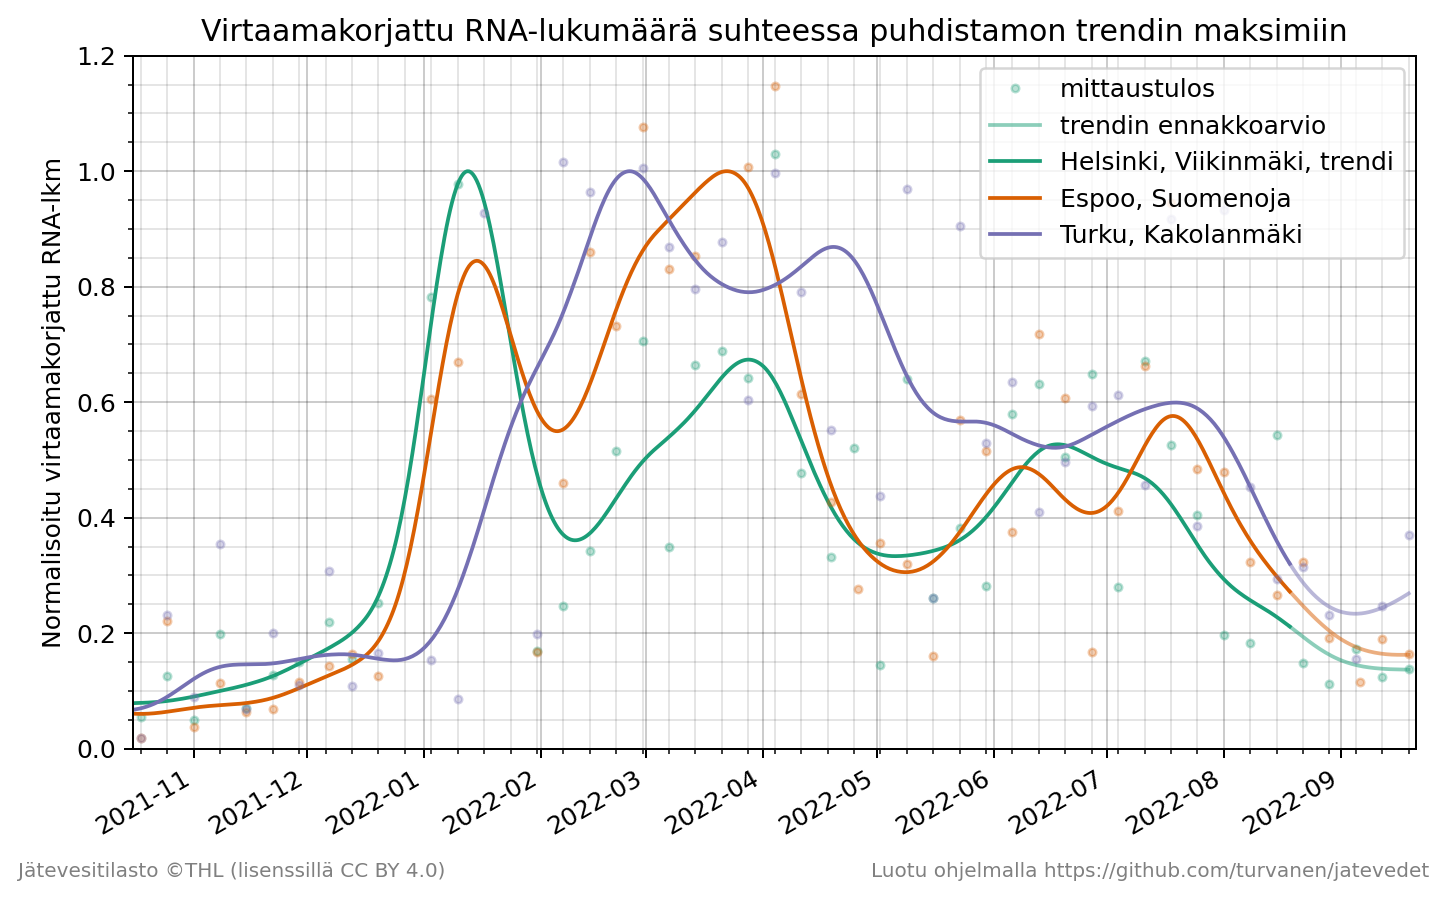

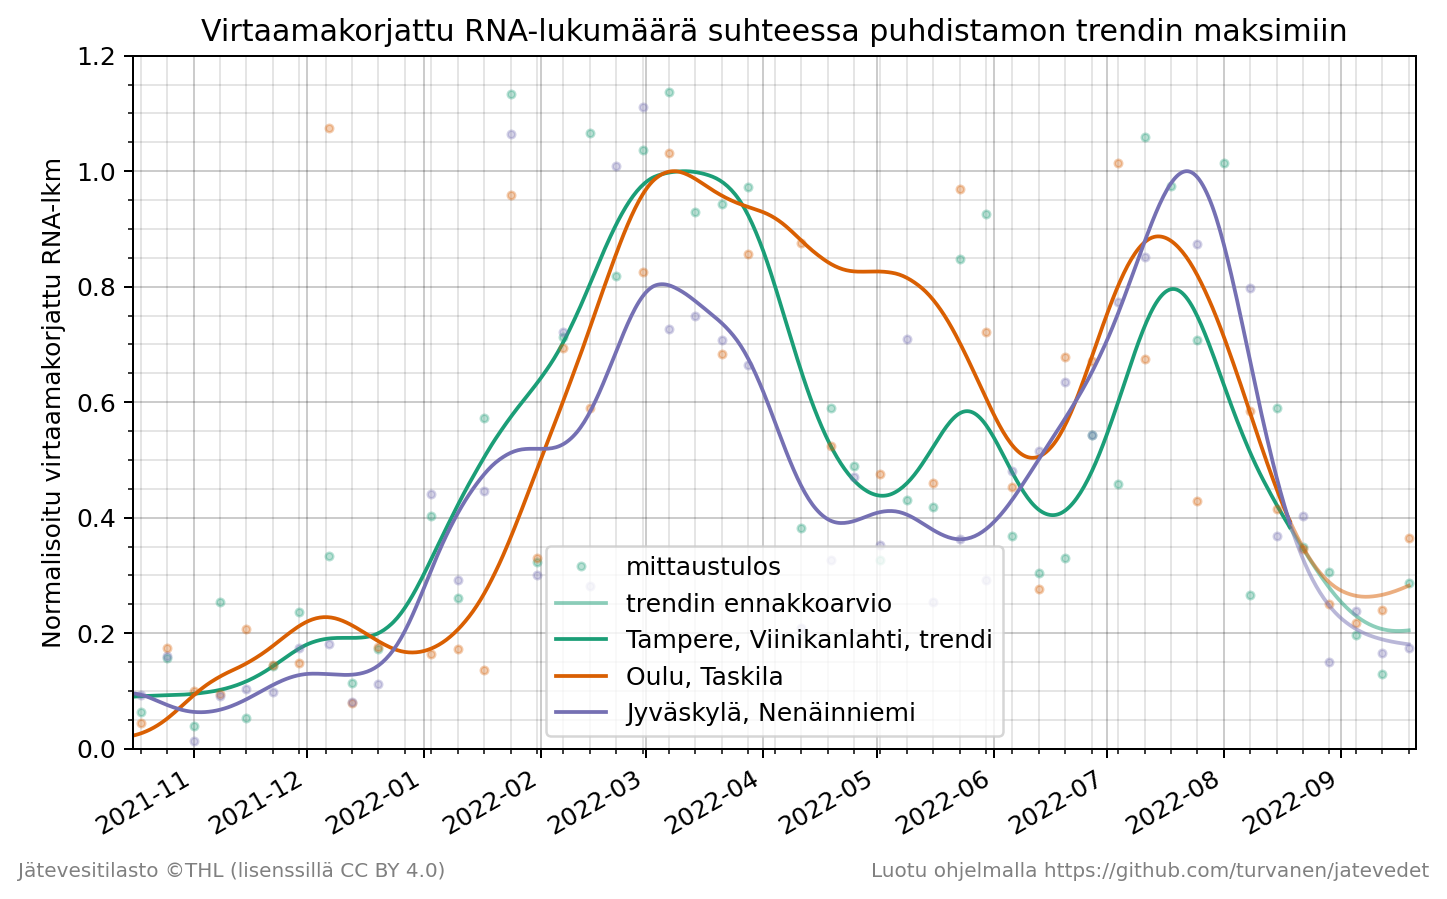

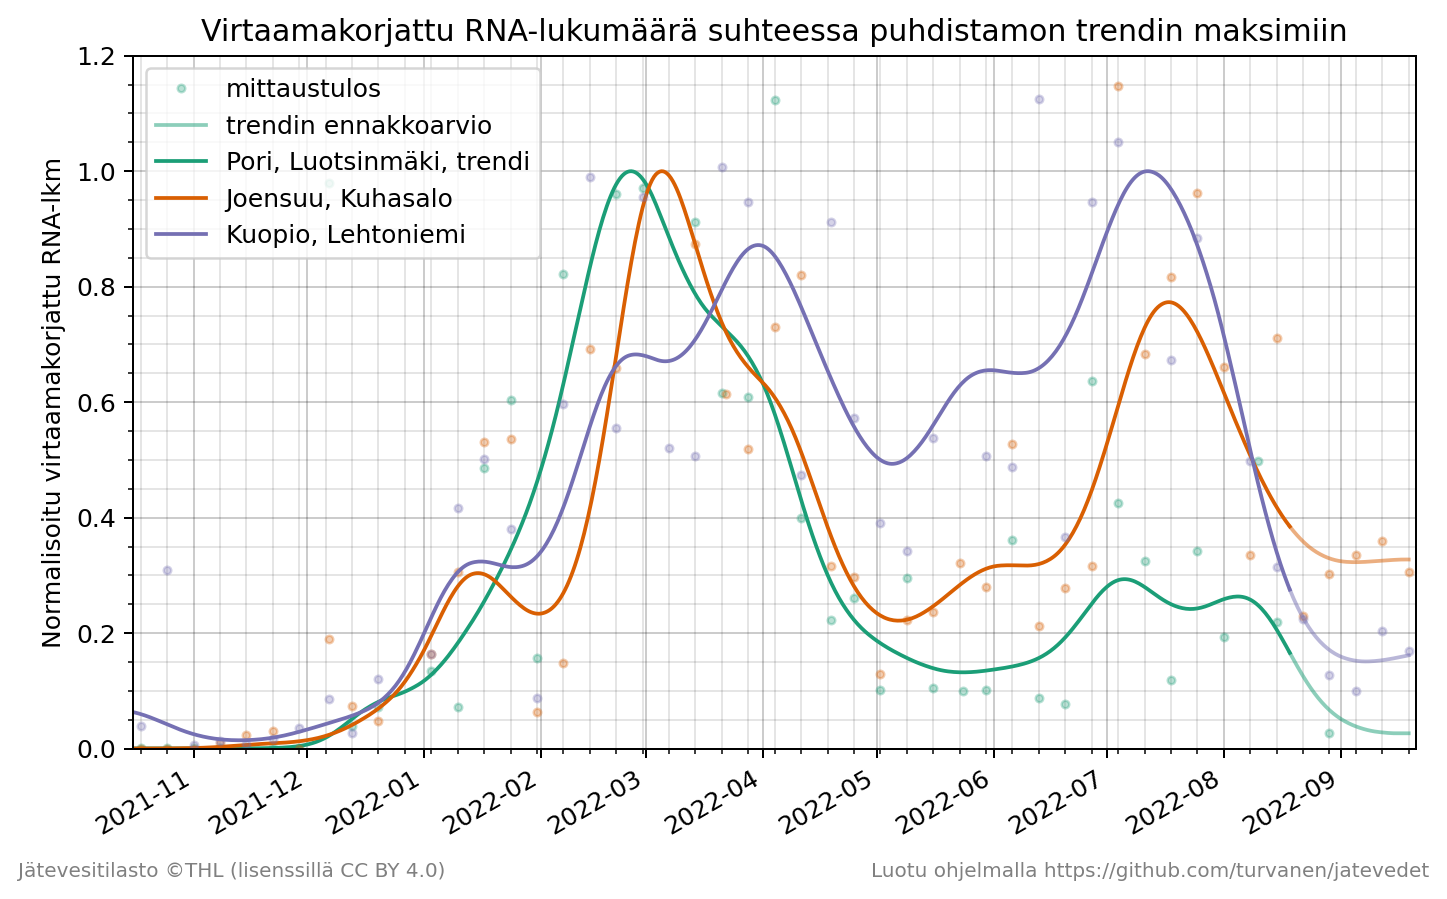

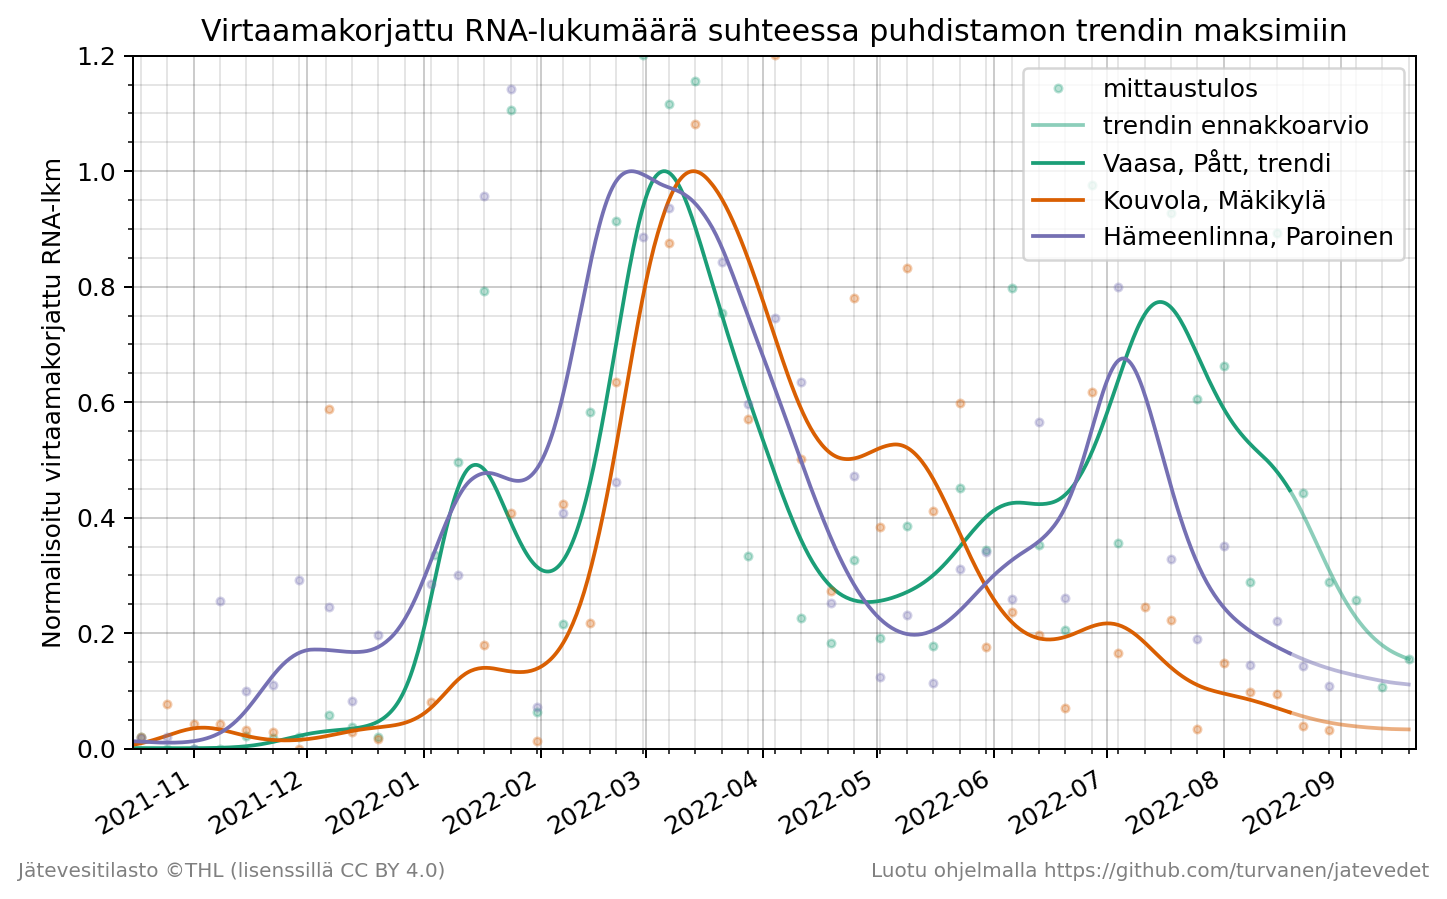

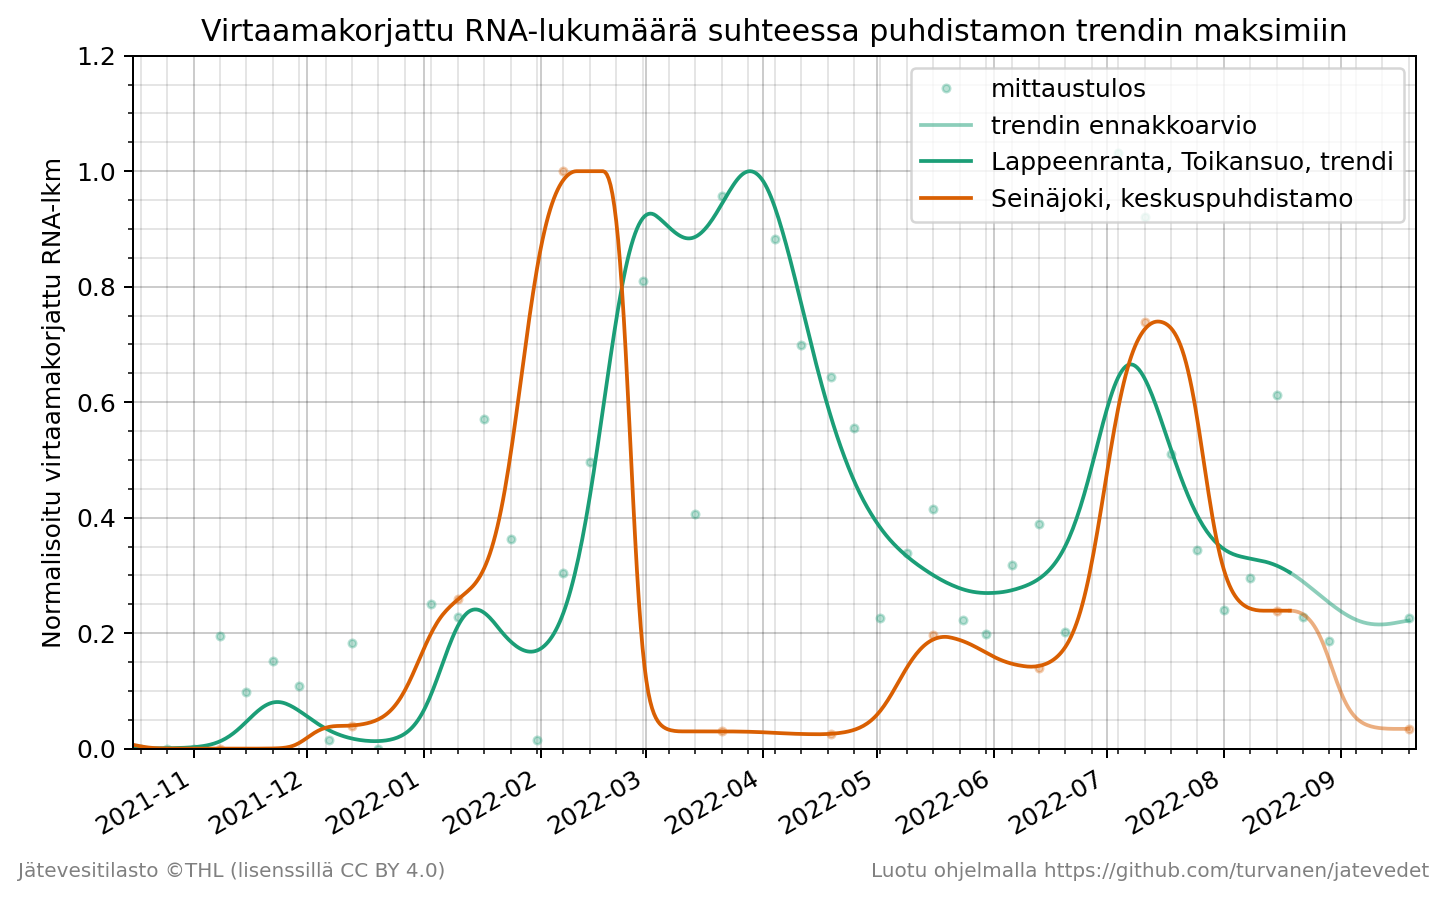

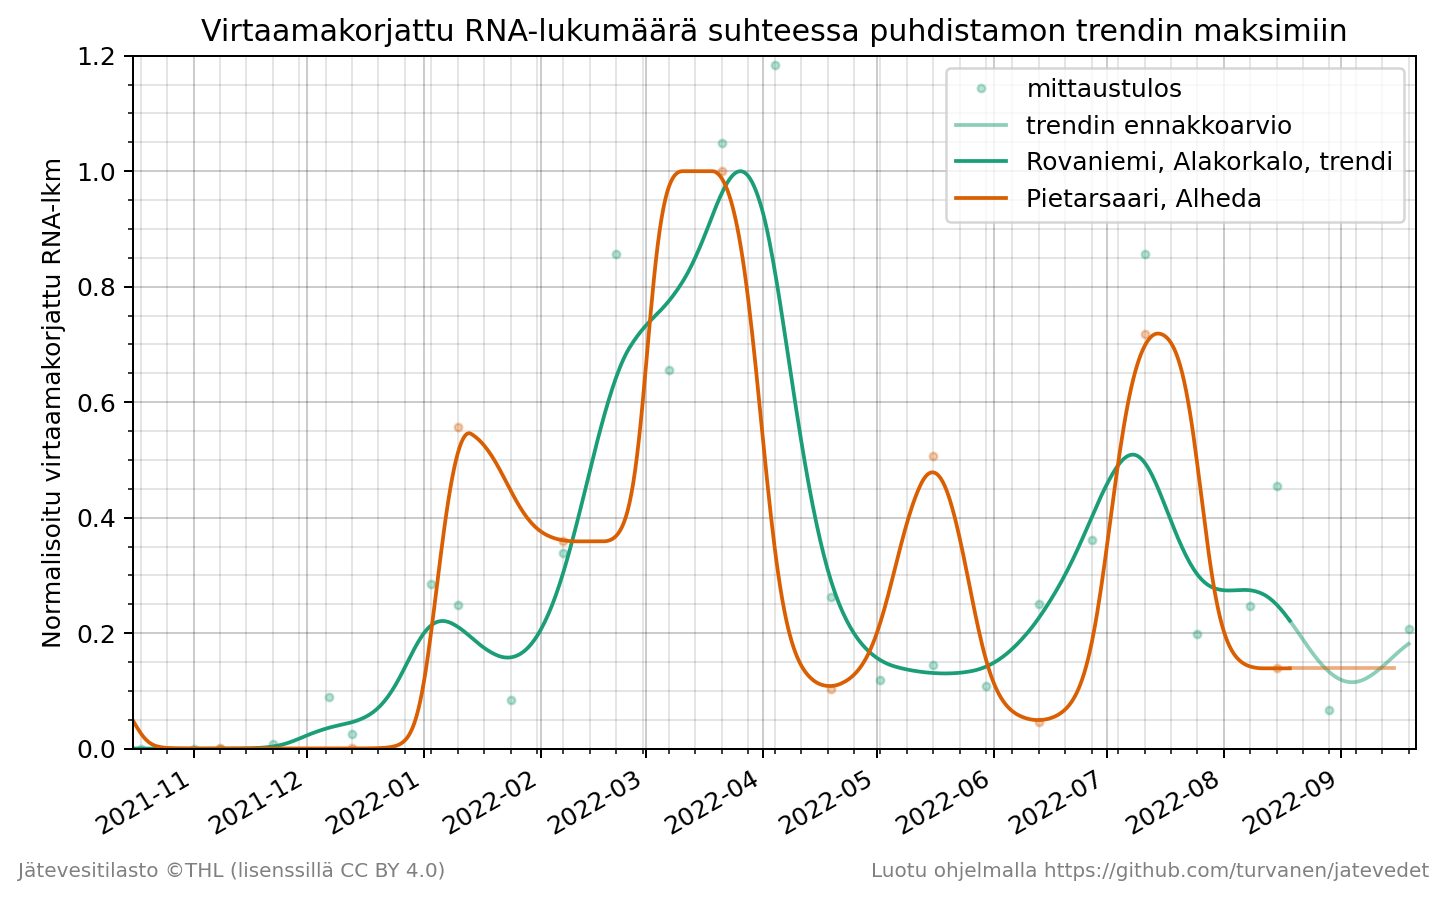

In [10]:
N = np.cumsum([0, 3, 3, 3, 3, 2, 2])
assert N[-1] == len(puhdistamot)

for i in range(len(N) - 1):
    fig, ax = trendikaavio(df, puhdistamot[N[i]:N[i+1]],
                           xlim_kw=xlim, 
                           ylim_kw=ylim,
                           dpi=view_dpi)

## Puhdistamojen virtaaman vaihtelu

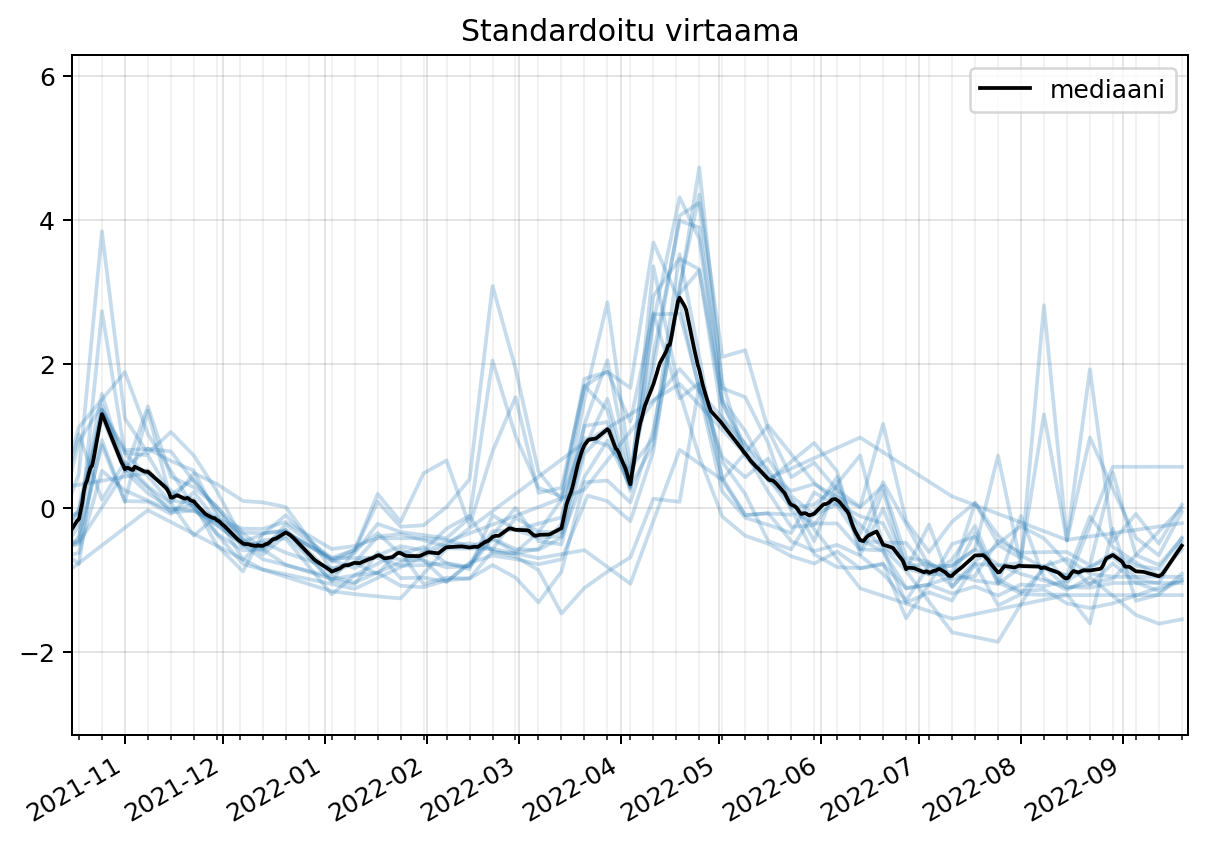

In [11]:
virtaamat = df["Virtaama"][puhdistamot]
virtaamat_std = (virtaamat.interpolate(axis=0) - virtaamat.mean(axis=0)) / virtaamat.std(axis=0)
virtaamat_std_m = virtaamat_std.median(axis=1)

fig, ax = plt.subplots(figsize=(8, 5), dpi=view_dpi)
plt.plot(df.index, virtaamat_std, "C0-", alpha=.25)
plt.plot(df.index, virtaamat_std_m, "k-", label="mediaani")
plt.title("Standardoitu virtaama")
ax.xaxis.set_minor_locator(WeekdayLocator(byweekday=MO))
ax.grid(which="major", axis="both", c="k", alpha=0.1)
ax.grid(which="minor", axis="both", c="k", alpha=0.05)
plt.xticks(rotation=30, ha="right")
plt.xlim(**xlim)
plt.legend()